In [47]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


In [3]:
dataset = pd.read_csv("mackeyglass.csv")
df_train = dataset[:-1500]
df_validation = dataset[-1500:-750]
df_test = dataset[-750:]

print(f"Dimensoes Treino: {df_train.shape}")
print(f"Dimensoes Validacao: {df_validation.shape}")
print(f"Dimensoes Teste: {df_test.shape}")

Dimensoes Treino: (3500, 2)
Dimensoes Validacao: (750, 2)
Dimensoes Teste: (750, 2)


In [35]:
class TimeSeriesDataLoader():
    """
    Classe responsável por transformar o dataset de uma série temporal em 
    matrizes que podem ser utilizadas numa regressão linear.
    """
    def __init__(self, k_attributes:int, l_prevision:int, df_dataset:pd.DataFrame):
        """
        Entradas:
            k_attributes (int): Número de entradas da janela da série temporal
            df_dataset (pd.DataFrame): DataFrame contendo a série temporal lida
            de um arquivo .csv
        """
        self.k_attributes = k_attributes
        self.df_dataset = df_dataset
        self.l_prevision = l_prevision

    def get_data(self):
        """
        Saídas:
            x (np.array): Matrix com K colunas compostas de K atributos de janela de predição
            y (np.array): Matrix contendo os valores de target
        """
        
        p_values = self.df_dataset["p"]
        # n_indices é o número máximo de linhas (exemplos de treinamento) que o dataset nos fornece
        n_indices = len(p_values) - self.k_attributes - self.l_prevision + 1
        x, y = [], []
        # Percorre todas as janelas de K elementos dentro da série temporal
        for index in range(0,n_indices):
            x.append(p_values[index:(index + self.k_attributes)])
            y.append(p_values.iloc[index + self.k_attributes + self.l_prevision -1])
        x = np.array(x)
        y = np.array(y)
        return x, y


K = int(input())
L = int(input())
print(f"K: {K}, L: {L}")
train_loader = TimeSeriesDataLoader(K, L, df_train)
x_train, y_train = train_loader.get_data()
train_loader = TimeSeriesDataLoader(K, L, df_validation)
x_validation, y_validation = train_loader.get_data()



K: 3, L: 7


In [51]:
reg = LinearRegression().fit(x_train, y_train)
train_prediction = reg.predict(x_train)
validation_prediction = reg.predict(x_validation)
validation_mse = mean_squared_error(y_validation, validation_prediction)
train_mse = mean_squared_error(y_train, train_prediction)

print(f"Train: {train_mse}, Validation {validation_mse}")

Train: 0.0016694719107774418, Validation 0.0016077060042981452


In [56]:
L = 7
train_mse_list = []
validation_mse_list = []
for K in range(1,51):
    train_loader = TimeSeriesDataLoader(K, L, df_train)
    x_train, y_train = train_loader.get_data()
    train_loader = TimeSeriesDataLoader(K, L, df_validation)
    x_validation, y_validation = train_loader.get_data()
    reg = LinearRegression().fit(x_train, y_train)
    train_prediction = reg.predict(x_train)
    validation_prediction = reg.predict(x_validation)
    validation_mse = np.sqrt(mean_squared_error(y_validation, validation_prediction))
    train_mse = np.sqrt(mean_squared_error(y_train, train_prediction))
    train_mse_list.append(train_mse)
    validation_mse_list.append(validation_mse)


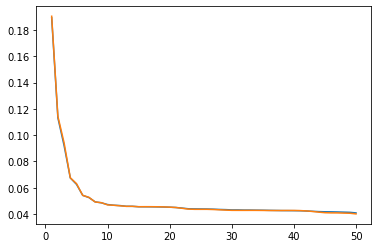

In [58]:
import matplotlib.pyplot as plt

plt.plot(range(1,51), train_mse_list)
plt.plot(range(1,51), validation_mse_list)
plt.show()

In [62]:
validation_mse_list
min(validation_mse_list)

0.0400962093507372